## 개요

#### o 제목 : 폐렴 진단기 성능개선
#### o DataSet : 캐글의 **Chest X-Ray Images (Pneumonia)** 
   * 5,863 images,3 directories(train, test, val), 2 categories (폐렴 / 정상)
   * Coronal plane(관상면. 인체를 앞뒤로 나누는 면) 자료

## 목차
#### 1. Set-up
#### 2. 데이터 가져오기(좌우반전 argmentation)
    * 데이터 수를 train(80) : val (20)으로 분할
    * tf.data 인스턴스 만들기
    * 라벨 데이터를 만드는 함수 만들기
    * 이미지 사이즈 통일하기
    * train 데이터 셋과 validation 데이터 셋 만들기
    * 좌우반전 argmentation시도
    
#### 3. 데이터 시각화(좌우 반전 augmentation)
#### 4. CNN 모델링(Batch Normalization과 Dropout 동시 사용)
    * Convolution block(conv_block()) 만들기
    * Dense Block 만들기
    * 모델함수 만들기
#### 5. 데이터 imbalance 처리
#### 6. 모델 훈련
#### 7. 결과 확인
#### 8. Data augmentation기법

#### Referrence

## 1. Set-up

In [59]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

* 앞으로 필요한 변수들 생성

In [60]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 20
EPOCHS = 15

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기

In [61]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- 데이터 수를 train(80) : val (20)으로 분할

In [62]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [63]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [64]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


* tf.data 인스턴스 만들기

    : tf.data는 tensorflow에서 학습시킬 때, mini-batch 작업 가능

In [65]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [66]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


* 파일 경로('NORMAL', 'PNEUMONIA') 이용해 라벨 데이터를 만드는 함수 만들기

In [67]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

* 이미지 사이즈 통일하기
    - decode_img 함수. process_path 함수 만들기
    - process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈 변경
    - get_label을 이용해서 라벨 값을 가져오기

In [68]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

* train 데이터 셋과 validation 데이터 셋 만들기
    - num_parallel_calls 파라미터에 AUTOTUNE변수를 이용해 데이터 처리속도 증가

In [69]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환.

* 이미지를 좌우 반전하는 augment()함수를 만들어 배치처리 함수에 추가

* shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택.

* repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용하면 자동으로 데이터를 맞춰줌.

* batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 할당.

* prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음.


* 좌우반전 argmentation시도

In [15]:
# 좌우 반전 augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=AUTOTUNE
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화 (좌우 반전 augmentation)


- Augmentation 적용 여부 확인
- 좌우 반전을 augment 함수로 적용하여 확인 
- show_augmented_batch() 함수를 이용해서 결과 사진 보기

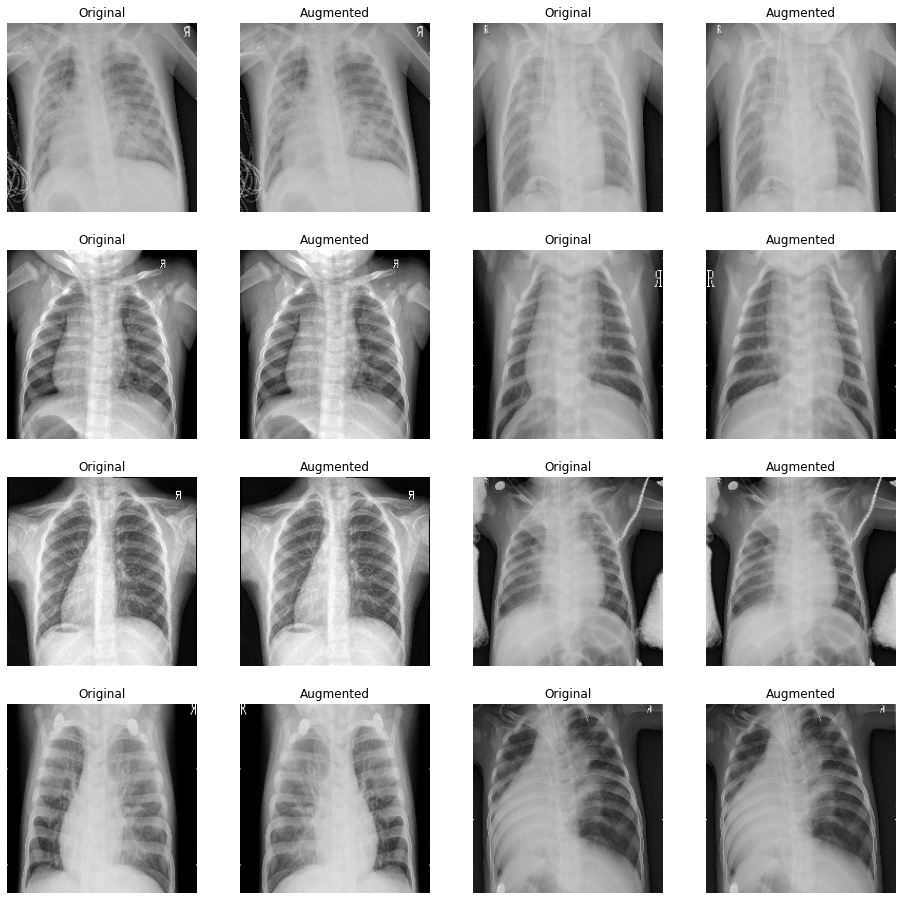

In [23]:
# show_batch 함수 수정: 원본 이미지와 augment된 이미지를 나란히 비교
def show_augmented_batch(image_batch, label_batch, augment_function):
    plt.figure(figsize=(16, 16))
    total_images = len(image_batch)
    for n in range(min(total_images, 8)):  # 한 번에 최대 8개 이미지를 보여줌
        # 원본 이미지 표시
        ax = plt.subplot(4, 4, 2 * n + 1)  # 4행 4열 레이아웃, 홀수 번호에 원본 배치
        plt.imshow(image_batch[n])
        plt.title("Original")
        plt.axis("off")
        
        # Augmentation 적용 및 표시
        augmented_image, _ = augment_function(image_batch[n], label_batch[n])
        ax = plt.subplot(4, 4, 2 * n + 2)  # 4행 4열 레이아웃, 짝수 번호에 Augmented 배치
        plt.imshow(augmented_image.numpy())
        plt.title("Augmented")
        plt.axis("off")

# Augmentation 적용 여부 확인
image_batch, label_batch = next(iter(train_ds.unbatch().batch(BATCH_SIZE)))

# 좌우 반전을 augment 함수로 적용하여 확인
show_augmented_batch(image_batch.numpy(), label_batch.numpy(), augment)


## 4. CNN 모델링
 (Batch Normalization과 Dropout 동시 사용)

* Convolution block(**conv_block()**) 만들기
    - Convolution을 두 번 진행 
    - Batch Normalization을 통해 Gradient vanishing, Gradient Exploding 해결
    - Max Pooling 하기

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

* Dense Block 만들기

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

* 모델함수 만들기

In [21]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리

**imbalance**

    - 데이터 중에 한 라벨이 너무 많은 경우를 지칭
    - imbalance한 데이터의 학습 효과 저조한 문제 발생
    - 해결하는 방법으로 **Weight balancing** 사용
    - Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법
    - Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원

In [22]:
# 'Normal' 이미지에 사용할 weight 세팅
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 

# 'Pneumonia' 이미지에 사용할 weight 세팅
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0  

# weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

* 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택
* 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss 사용
* optimizer로 'adam' 사용
* 성과 측정 metrics으로 'accuracy', 'precision', 'recall' 사용

In [23]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 130s 403ms/step - loss: 0.3758 - accuracy: 0.8331 - precision: 0.9520 - recall: 0.8169 - val_loss: 0.6706 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 106s 406ms/step - loss: 0.2188 - accuracy: 0.9191 - precision: 0.9766 - recall: 0.9133 - val_loss: 1.2971 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 109s 419ms/step - loss: 0.1764 - accuracy: 0.9325 - precision: 0.9789 - recall: 0.9291 - val_loss: 0.7593 - val_accuracy: 0.7385 - val_precision: 0.7372 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 122s 469ms/step - loss: 0.1627 - accuracy: 0.9361 - precision: 0.9827 - recall: 0.9306 - val_loss: 0.5504 - val_accuracy: 0.7846 - val_precision: 0.7726 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 123s 474ms/step - loss: 0.1462 - a

## 7. 결과 확인

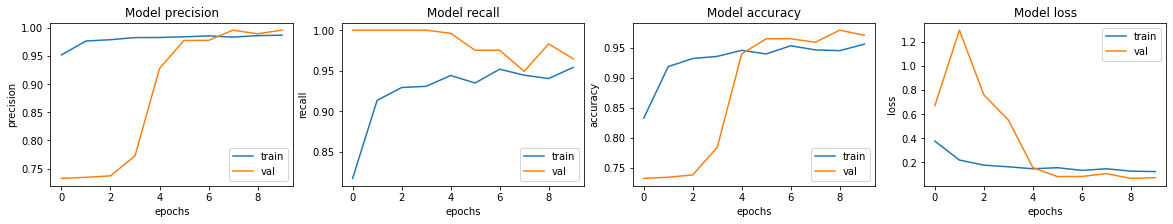

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

* 테스트 데이터로 모델 평가

In [26]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 112ms/step - loss: 0.6210 - accuracy: 0.8221 - precision: 0.7864 - recall: 0.9821
Loss: 0.6210359930992126,
Accuracy: 0.8221153616905212,
Precision: 0.7864476442337036,
Recall: 0.9820512533187866


## 8. ResNet-18 구현

In [56]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, AveragePooling2D, Dense, Flatten, Input

# Residual Block
def Residual_block(inputs, filters, kernel_size=3, strides=1):
    """
    ResNet Residual Block
    Args:
        inputs: Input tensor
        filters: Number of filters for the Conv2D layers
        kernel_size: Size of the convolution kernel (default: 3x3)
        strides: Stride of the convolution (default: 1)
    Returns:
        Output tensor after applying the residual block
    """
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    
    # Skip connection
    if strides != 1 or inputs.shape[-1] != filters:
        # Match dimensions using 1x1 convolution for skip connection
        inputs = Conv2D(filters=filters, kernel_size=1, strides=strides, padding="same")(inputs)
        inputs = BatchNormalization()(inputs)
    
    x = Add()([x, inputs])
    x = ReLU()(x)
    
    return x

# ResNet-18
def ResNet18(input_shape, filters=[64, 128, 256, 512]):
    """
    Builds the ResNet-18 model.
    Args:
        input_shape: Shape of the input tensor (e.g., (224, 224, 3))
        num_classes: Number of output classes
        filters: List of filters for each stage
    Returns:
        ResNet-18 model
    """

    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv2D(filters=filters[0], kernel_size=7, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding="same")(x)
    
    # Residual Blocks
    for i, f in enumerate(filters):
        strides = 1 if i == 0 else 2  # Only downsample from conv3_x onwards
        x = Residual_block(x, filters=f, strides=strides)  # First block in stage
        x = Residual_block(x, filters=f)  # Second block in stage
    
    # Average Pooling
    x = AveragePooling2D(pool_size=6)(x)
    x = Flatten()(x)
    
    # Fully Connected Layer
    outputs = Dense(1, activation="softmax")(x)
    
    # Create Model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


## 9. 데이터 imbalance 처리`

In [57]:
# 'Normal' 이미지에 사용할 weight 세팅
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 

# 'Pneumonia' 이미지에 사용할 weight 세팅
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0  

# weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 10. ResNet-18 모델 훈련

In [58]:
input_shape = (180, 180, 3)

from tensorflow.keras.optimizers import Adam

with tf.device('/GPU:0'):
    # ResNet18 모델 생성
    model = ResNet18(input_shape=input_shape)

    # 컴파일
    model.compile(
        optimizer=Adam(learning_rate=1e-4),  # Reduced learning rate
        loss='sparse_categorical_crossentropy',  # Adjust based on label encoding
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )

    # 학습 실행
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )


Epoch 1/15
  1/209 [..............................] - ETA: 35:35 - loss: nan - accuracy: 0.6000 - precision: 0.6000 - recall: 1.0000

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_6/dense_6/Softmax:0) = ] [[nan][nan][nan]...] [y (Cast_8/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_1/assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_greater_equal_1/Assert/AssertGuard/pivot_f/_23/_61]]
  (1) Invalid argument:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_6/dense_6/Softmax:0) = ] [[nan][nan][nan]...] [y (Cast_8/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_1/assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_37823]

Function call stack:
train_function -> train_function


## 회고

* X-Ray의학 상식 습득에 도움
* 의학에서의 ai효과 기대
    - 조기진단, 개별 맞춤 치료, 최소의 부작용, 최대의 효과
* CNN이 실생활에 적용된 사례

### Reference

* 실습코드: 캐글 노트북(TensorFlow Pneumonia Classification on X-rays) 기반 작성(https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays)
* CNN, Convolutional Neural Network 요약(http://taewan.kim/post/cnn/)
* Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift(https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)
* Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks(https://arxiv.org/pdf/1905.05928)